In [1]:
import datetime
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px # to plot the time series plot
from sklearn import metrics # for the evaluation
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
import tensorflow as tf 
from scipy import stats

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

# I. Load data

In [2]:
OF = pd.read_pickle("Related_dataset/Opinion_Finder_result.pkl")
GPOMS = pd.read_pickle("Related_dataset/GPOMS_result.pkl")
DJIA = pd.read_pickle("Related_dataset/DJIA_filled_missing_value.pkl")

# II. Prepare dataset

In [3]:
# process OF dataframe
OF_prim = OF.drop(columns=['tweets_processed', 'tweet_size'])
OF_prim = OF_prim.reset_index()
OF_prim = OF_prim.rename({'date_prune': 'Dates'}, axis=1) 

# process GPOMS dataframe
GPOMS_pivot = GPOMS.drop(columns=['tweets_processed', 'tweet_size', 'GPOMS_preprocess_data', 'GPOMS_sum','sum_index', 'avg_index'])
GPOMS_pivot[['Calm','Kind','Happy','Alert','Sure','Vital']] = pd.DataFrame(GPOMS.GPOMS_avg.tolist(), index= GPOMS.index)
GPOMS_pivot = GPOMS_pivot.drop(['GPOMS_avg'], axis=1)
GPOMS_pivot = GPOMS_pivot.reset_index()
GPOMS_pivot = GPOMS_pivot.rename({'date_prune': 'Dates'}, axis=1) 

# process DJIA dataframe
DJIA['Dates'] = DJIA['Dates'].astype(str)

In [4]:
combine_df = OF_prim.merge(GPOMS_pivot, on='Dates')
combine_df = combine_df.merge(DJIA, on='Dates', how='inner')
combine_df

,Dates,OF_transform,Calm,Kind,Happy,Alert,Sure,Vital,Close
0,2020-04-09,-0.380042,0.073364,0.191523,-0.115305,0.346767,0.136158,0.155670,23719.369141
1,2020-04-10,0.740977,0.092862,0.195467,-0.102743,0.342314,0.130042,0.118410,23555.069336
2,2020-04-11,0.456476,0.061887,0.278887,-0.064833,0.340592,0.101464,0.160457,23472.919434
3,2020-04-12,0.403397,0.082763,0.216780,-0.062001,0.329557,0.111304,0.079260,23431.844482
4,2020-04-13,0.144374,0.079693,0.222743,-0.091400,0.338160,0.130949,0.137338,23390.769531
...,...,...,...,...,...,...,...,...,...
72,2020-07-12,0.235669,0.078391,0.181213,-0.097056,0.369545,0.147573,0.078480,26083.175781
73,2020-07-13,-0.322718,0.082311,0.183053,-0.082040,0.357759,0.154204,0.122646,26085.800781
74,2020-07-14,-0.271762,0.098220,0.186504,-0.089044,0.359141,0.150973,0.111742,26642.589844
75,2020-07-15,0.002123,0.084568,0.184610,-0.079527,0.337375,0.146182,0.102206,26870.099609


# III. Build Neural Network model to predict DJIA
input: 
1. The past 3 days of DJIA values
2. Opinion Finder mood data (past 3 days)

Time period (in thesis): 
> Train: 2008-2-28 ~ 2008-11-28 (10 months)

> Test: 2008-12-1 ~ 2008-12-19 (19 days)

Time period (in this project): 
> Train: 2020-4-9 ~ 2020-6-23 (54 days, some missing data)

> Test: 2020-6-24 ~ 2022-7-16 (20 days)


In [5]:
threshold = 54

Part 1 : 只提供過去三天收盤價資訊

Single variable

> X[0]: [[ [1], [2], [3]]] 

> y[0]: [4]

In [6]:
def mape(actual, predict): 
    actual, predict = np.array(actual), np.array(predict)
    return np.mean(np.abs((actual - predict) / actual)) * 100

def direction(actual, predict): 
    prev_act = actual[0]
    prev_pred = predict[0]
    true = []
    res = []
    for i, j in zip(actual[1:], predict[1:]): 
        if i>=prev_act:
            true.append(1)
        else:
            true.append(-1)
        if j>=prev_pred:
            res.append(1)
        else:
            res.append(-1)
        prev_act = i
        prev_pred = j
    denorminator = len(actual) -1
    numerator = 0
    for i, j in zip(true, res):
        if i==j:
            numerator += 1
    return (numerator / denorminator)

In [7]:
tmp = combine_df['Close']
tmp = tmp.to_numpy().reshape(-1, 1)
scaler = MinMaxScaler()
temp = scaler.fit_transform(tmp)
temp.shape

(77, 1)

In [8]:
def df_to_X_y(df, window_size=3):
    X = []
    y = []
    for i in range(len(df)-window_size):
        row = [a for a in df[i:i+window_size]]
        X.append(row)
        label = df[i+window_size]
        y.append(label)
    return np.array(X), np.array(y)

In [9]:
WINDOW_SIZE = 3
X1, y1 = df_to_X_y(temp, WINDOW_SIZE)
X1.shape, y1.shape # NUMBER of data, WINDOW_size, number of feature

((74, 3, 1), (74, 1))

In [10]:
X_train1, y_train1 = X1[:threshold], y1[:threshold]
X_test1, y_test1 = X1[threshold:], y1[threshold:]
X_train1.shape, y_train1.shape, X_test1.shape, y_test1.shape

((54, 3, 1), (54, 1), (20, 3, 1), (20, 1))

In [11]:
model1 = Sequential()
model1.add(InputLayer((WINDOW_SIZE, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [12]:
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[RootMeanSquaredError()])

model1.fit(X_train1, y_train1, epochs=10)

Epoch 1/10
2/2 [==============================] - 5s 8ms/step - loss: 0.2640 - root_mean_squared_error: 0.5139
Epoch 2/10
2/2 [==============================] - 0s 7ms/step - loss: 0.1197 - root_mean_squared_error: 0.3460
Epoch 3/10
2/2 [==============================] - 0s 6ms/step - loss: 0.0353 - root_mean_squared_error: 0.1879
Epoch 4/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0602 - root_mean_squared_error: 0.2453
Epoch 5/10
2/2 [==============================] - 0s 8ms/step - loss: 0.0402 - root_mean_squared_error: 0.2005
Epoch 6/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0244 - root_mean_squared_error: 0.1561
Epoch 7/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0364 - root_mean_squared_error: 0.1908
Epoch 8/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0364 - root_mean_squared_error: 0.1907
Epoch 9/10
2/2 [==============================] - 0s 6ms/step - loss: 0.0228 - root_mean_squared_error: 0.1509
E

In [13]:
def plot_modal_res(df, tp):
    plt.title(f"{tp} result")
    plt.plot(df[f'{tp} Predictions'], c='b')
    plt.plot(df['Actuals'], c='g')
    plt.legend(["Modal Predict", "Ground True"], loc ="lower right")
    plt.show()

2/2 [==============================] - 1s 4ms/step


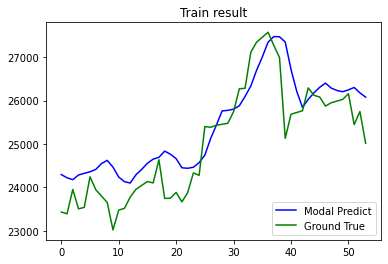

In [14]:
# train result
train_predictions = model1.predict(X_train1).flatten()
pred = scaler.inverse_transform(train_predictions.reshape(-1, 1))
pred = pred.reshape(-1,)
act = scaler.inverse_transform(y_train1)
act = act.reshape(-1,)

train_results1 = pd.DataFrame(data={
    'Train Predictions':pred, 
    'Actuals':act})

plot_modal_res(train_results1, 'Train')

1/1 [==============================] - 0s 37ms/step


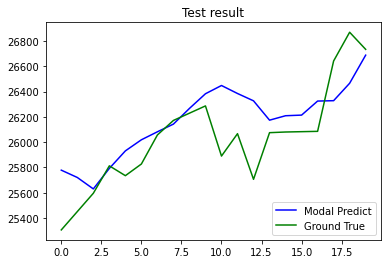

In [15]:
# Test result
test_predictions = model1.predict(X_test1).flatten()
pred = scaler.inverse_transform(test_predictions.reshape(-1, 1))
pred = pred.reshape(-1,)
act = scaler.inverse_transform(y_test1)
act = act.reshape(-1,)

test_results1 = pd.DataFrame(data={
    'Test Predictions':pred, 
    'Actuals':act})

plot_modal_res(test_results1, 'Test')

A little bit overfitting.

***Try to use delta***

In [16]:
# 加入delta
Data_new = combine_df.copy()

Data_new['tomorrow'] = Data_new['Close'].shift(-1)
Data_new.drop(Data_new.tail(1).index, inplace=True)
Data_new['delta'] = Data_new['tomorrow'] - Data_new['Close']
tmp3 = Data_new['delta']
tmp3 = tmp3.to_numpy().reshape(-1, 1)
scaler = MinMaxScaler()
temp3 = scaler.fit_transform(tmp3)

WINDOW_SIZE = 3
X3, y3 = df_to_X_y(temp3, WINDOW_SIZE)
X3.shape, y3.shape # NUMBER of data, WINDOW_size, number of feature

X_train3, y_train3 = X3[:threshold], y3[:threshold]
X_test3, y_test3 = X3[threshold:], y3[threshold:]
X_train3.shape, y_train3.shape, X_test3.shape, y_test3.shape

((54, 3, 1), (54, 1), (19, 3, 1), (19, 1))

In [17]:
model3 = Sequential()
model3.add(InputLayer((WINDOW_SIZE, 1)))
model3.add(LSTM(64))
model3.add(Dense(8, 'relu'))
model3.add(Dense(1, 'linear'))

model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [18]:
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[RootMeanSquaredError()])

model3.fit(X_train3, y_train3, epochs=10)

Epoch 1/10
2/2 [==============================] - 5s 6ms/step - loss: 0.3619 - root_mean_squared_error: 0.6016
Epoch 2/10
2/2 [==============================] - 0s 7ms/step - loss: 0.1104 - root_mean_squared_error: 0.3322
Epoch 3/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0397 - root_mean_squared_error: 0.1993
Epoch 4/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0816 - root_mean_squared_error: 0.2857
Epoch 5/10
2/2 [==============================] - 0s 6ms/step - loss: 0.0270 - root_mean_squared_error: 0.1643
Epoch 6/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0429 - root_mean_squared_error: 0.2072
Epoch 7/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0568 - root_mean_squared_error: 0.2384
Epoch 8/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0459 - root_mean_squared_error: 0.2143
Epoch 9/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0295 - root_mean_squared_error: 0.1719
E

2/2 [==============================] - 1s 4ms/step


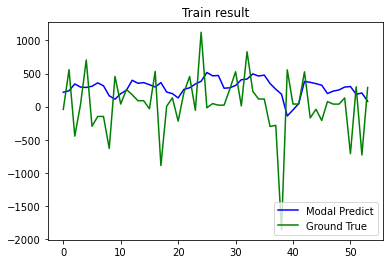

In [19]:
# train result
train_predictions = model3.predict(X_train3).flatten()
pred = scaler.inverse_transform(train_predictions.reshape(-1, 1))
pred = pred.reshape(-1,)
act = scaler.inverse_transform(y_train3)
act = act.reshape(-1,)

train_results3 = pd.DataFrame(data={
    'Train Predictions':pred, 
    'Actuals':act})

plot_modal_res(train_results3, 'Train')

1/1 [==============================] - 0s 35ms/step


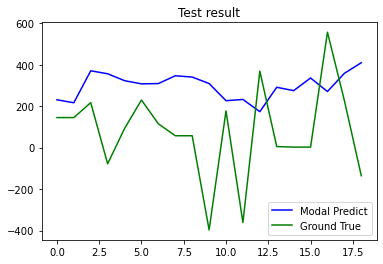

In [20]:
# Test result
test_predictions = model3.predict(X_test3).flatten()
pred = scaler.inverse_transform(test_predictions.reshape(-1, 1))
pred = pred.reshape(-1,)
act = scaler.inverse_transform(y_test3)
act = act.reshape(-1,)

test_results3 = pd.DataFrame(data={
    'Test Predictions':pred, 
    'Actuals':act})

plot_modal_res(test_results3, 'Test')

In [21]:
# Part 1: past three days' DJIA data
print("MAPE:", mape(test_results3['Actuals'], test_results3['Test Predictions']).round(3), "%")
print("Directional correction rate:", "{0:.0%}".format(direction(test_results3['Actuals'], test_results3['Test Predictions'])) )

MAPE: 1665.689 %
Directional correction rate: 28%


結果真d差

***Part 2: 提供過去3天的DJIA + OF 資料***

multi-variable

> X[0]: [[ [1-1, 1-2, ..], [2-1, 2-2, ...], [3-1, 3-2, ...]]]

> y[0]: [4]


In [22]:
temp2 = combine_df[['Close','OF_transform']]
mms_close = MinMaxScaler()
mms_OF = MinMaxScaler()
temp2['Close'] = mms_close.fit_transform(np.array(temp2['Close']).reshape(-1, 1))
temp2['OF_transform'] = mms_OF.fit_transform(np.array(temp2['OF_transform']).reshape(-1, 1))

In [23]:
def df_to_X_y2(df, window_size=3):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)

In [24]:
WINDOW_SIZE = 3
NUM_FEATURE = 2
X2, y2 = df_to_X_y2(temp2, WINDOW_SIZE)
X2.shape, y2.shape # number of data, # size of window, number of features

((74, 3, 2), (74,))

In [25]:
X_train2, y_train2 = X2[:threshold], y2[:threshold]
X_test2, y_test2 = X2[threshold:], y2[threshold:]
X_train2.shape, y_train2.shape, X_test2.shape, y_test2.shape

((54, 3, 2), (54,), (20, 3, 2), (20,))

In [26]:
model2 = Sequential()
model2.add(InputLayer((WINDOW_SIZE, NUM_FEATURE)))
model2.add(LSTM(64))
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))

model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                17152     
                                                                 
 dense_4 (Dense)             (None, 8)                 520       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,681
Trainable params: 17,681
Non-trainable params: 0
_________________________________________________________________


In [27]:
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[RootMeanSquaredError()])
model2.fit(X_train2, y_train2, epochs=10)

Epoch 1/10
2/2 [==============================] - 5s 6ms/step - loss: 0.1672 - root_mean_squared_error: 0.4089
Epoch 2/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0546 - root_mean_squared_error: 0.2336
Epoch 3/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0598 - root_mean_squared_error: 0.2445
Epoch 4/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0320 - root_mean_squared_error: 0.1788
Epoch 5/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0352 - root_mean_squared_error: 0.1876
Epoch 6/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0254 - root_mean_squared_error: 0.1594
Epoch 7/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0149 - root_mean_squared_error: 0.1219
Epoch 8/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0209 - root_mean_squared_error: 0.1446
Epoch 9/10
2/2 [==============================] - 0s 6ms/step - loss: 0.0166 - root_mean_squared_error: 0.1290
E

2/2 [==============================] - 1s 4ms/step


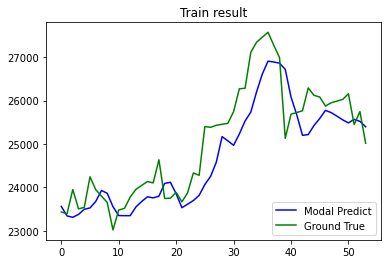

In [28]:
# train result
train_predictions2 = model2.predict(X_train2).flatten()
pred = mms_close.inverse_transform(train_predictions2.reshape(-1, 1))
pred = pred.reshape(-1,)
act = mms_close.inverse_transform(y_train2.reshape(-1, 1))
act = act.reshape(-1,)

train_results2 = pd.DataFrame(data={
    'Train Predictions':pred, 
    'Actuals':act})

plot_modal_res(train_results2, 'Train')

1/1 [==============================] - 0s 37ms/step


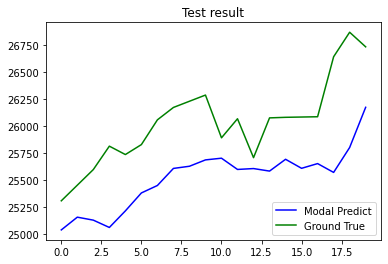

In [29]:
# Test result
test_predictions2 = model2.predict(X_test2).flatten()
pred = mms_close.inverse_transform(test_predictions2.reshape(-1, 1))
pred = pred.reshape(-1,)
act = mms_close.inverse_transform(y_test2.reshape(-1, 1))
act = act.reshape(-1,)

test_results2 = pd.DataFrame(data={
    'Test Predictions':pred, 
    'Actuals':act})

plot_modal_res(test_results2, 'Test')

# IV. Compute MAPE & Direction correct rate

In [30]:
# Part 1: past three days' DJIA data
print("MAPE:", mape(test_results1['Actuals'], test_results1['Test Predictions']).round(3), "%")
print("Directional correction rate:", "{0:.0%}".format(direction(test_results1['Actuals'], test_results1['Test Predictions'])) )

MAPE: 0.815 %
Directional correction rate: 63%


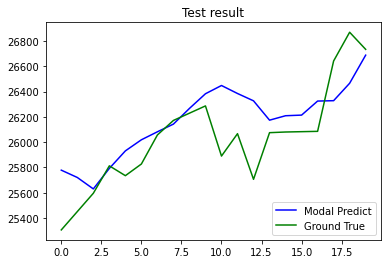

In [31]:
plot_modal_res(test_results1, 'Test')

In [32]:
# Part 2: past three days' DJIA data + Opinion Finder data
print("MAPE: ", mape(test_results2['Actuals'], test_results2['Test Predictions']).round(3), "%")
print("Directional correction rate:", "{0:.0%}".format(direction(test_results2['Actuals'], test_results2['Test Predictions'])) )

MAPE:  1.988 %
Directional correction rate: 47%


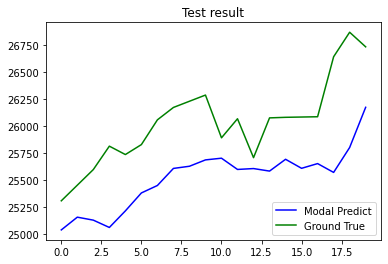

In [33]:
plot_modal_res(test_results2, 'Test')

reference: 

https://colab.research.google.com/drive/1b3CUJuDOmPmNdZFH3LQDmt5F0K3FZhqD?usp=sharing#scrollTo=FmwshpETs-jE


In [34]:
tmp = test_results2.copy()
tmp['pred_shift'] = tmp['Test Predictions'].shift(1)
tmp['Actuals_shift'] = tmp['Actuals'].shift(1)

tmp['pred_dire'] = tmp['Test Predictions'] - tmp['pred_shift']
tmp['pred_dire'] = tmp['pred_dire'].apply(lambda x: x>0)

tmp['act_dire'] = tmp['Actuals'] - tmp['Actuals_shift']
tmp['act_dire'] = tmp['act_dire'].apply(lambda x: x>0)
tmp

,Test Predictions,Actuals,pred_shift,Actuals_shift,pred_dire,act_dire
0,25035.501953,25305.675781,NaN,NaN,False,False
1,25153.832031,25450.738281,25035.501953,25305.675781,True,True
2,25126.158203,25595.800781,25153.832031,25450.738281,False,True
3,25058.277344,25812.880859,25126.158203,25595.800781,False,True
4,25212.054688,25734.970703,25058.277344,25812.880859,True,False
5,25378.673828,25827.359375,25212.054688,25734.970703,True,True
6,25447.875000,26057.194336,25378.673828,25827.359375,True,True
7,25606.228516,26172.111816,25447.875000,26057.194336,True,True
8,25626.382812,26229.570557,25606.228516,26172.111816,True,True
9,25685.333984,26287.029297,25626.382812,26229.570557,True,True


# Confidence Interval

In [35]:
MAPE = []
correction = []
NUM_FEATURE = 2

for i in range(100):
    model_k = Sequential()
    model_k.add(InputLayer((WINDOW_SIZE, NUM_FEATURE)))
    model_k.add(LSTM(64))
    model_k.add(Dense(8, 'relu'))
    model_k.add(Dense(1, 'linear'))

    model_k.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[RootMeanSquaredError()])
    model_k.fit(X_train2, y_train2, epochs=10)

    # Test result
    test_predictions2 = model_k.predict(X_test2).flatten()
    pred = mms_close.inverse_transform(test_predictions2.reshape(-1, 1))
    pred = pred.reshape(-1,)
    act = mms_close.inverse_transform(y_test2.reshape(-1, 1))
    act = act.reshape(-1,)

    test_results2 = pd.DataFrame(data={
        'Test Predictions':pred, 
        'Actuals':act})

    # Part 2: past three days' DJIA data + Opinion Finder data
    MAPE.append(mape(test_results2['Actuals'], test_results2['Test Predictions']).round(3))
    correction.append(direction(test_results2['Actuals'], test_results2['Test Predictions']))

Epoch 1/10
2/2 [==============================] - 5s 7ms/step - loss: 0.2340 - root_mean_squared_error: 0.4837
Epoch 2/10
2/2 [==============================] - 0s 7ms/step - loss: 0.1104 - root_mean_squared_error: 0.3322
Epoch 3/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0690 - root_mean_squared_error: 0.2626
Epoch 4/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0716 - root_mean_squared_error: 0.2676
Epoch 5/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0280 - root_mean_squared_error: 0.1674
Epoch 6/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0374 - root_mean_squared_error: 0.1933
Epoch 7/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0409 - root_mean_squared_error: 0.2023
Epoch 8/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0263 - root_mean_squared_error: 0.1621
Epoch 9/10
2/2 [==============================] - 0s 6ms/step - loss: 0.0182 - root_mean_squared_error: 0.1347
E

2/2 [==============================] - 0s 5ms/step - loss: 0.0146 - root_mean_squared_error: 0.1207
Epoch 10/10
1/1 [==============================] - 1s 956ms/step
Epoch 1/10
2/2 [==============================] - 5s 7ms/step - loss: 0.1810 - root_mean_squared_error: 0.4254
Epoch 2/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0673 - root_mean_squared_error: 0.2595
Epoch 3/10
2/2 [==============================] - 0s 6ms/step - loss: 0.0710 - root_mean_squared_error: 0.2665
Epoch 4/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0320 - root_mean_squared_error: 0.1788
Epoch 5/10
2/2 [==============================] - 0s 6ms/step - loss: 0.0375 - root_mean_squared_error: 0.1937
Epoch 6/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0350 - root_mean_squared_error: 0.1870
Epoch 7/10
2/2 [==============================] - 0s 6ms/step - loss: 0.0213 - root_mean_squared_error: 0.1461
Epoch 8/10
2/2 [==============================] - 0s 7ms/s

2/2 [==============================] - 0s 7ms/step - loss: 0.0181 - root_mean_squared_error: 0.1345
Epoch 10/10
1/1 [==============================] - 1s 933ms/step
Epoch 1/10
2/2 [==============================] - 4s 7ms/step - loss: 0.2054 - root_mean_squared_error: 0.4533
Epoch 2/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0511 - root_mean_squared_error: 0.2260
Epoch 3/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0693 - root_mean_squared_error: 0.2632
Epoch 4/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0366 - root_mean_squared_error: 0.1912
Epoch 5/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0317 - root_mean_squared_error: 0.1781
Epoch 6/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0319 - root_mean_squared_error: 0.1785
Epoch 7/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0188 - root_mean_squared_error: 0.1371
Epoch 8/10
2/2 [==============================] - 0s 6ms/s

2/2 [==============================] - 0s 7ms/step - loss: 0.0137 - root_mean_squared_error: 0.1171
Epoch 10/10
1/1 [==============================] - 1s 949ms/step
Epoch 1/10
2/2 [==============================] - 4s 7ms/step - loss: 0.1760 - root_mean_squared_error: 0.4195
Epoch 2/10
2/2 [==============================] - 0s 6ms/step - loss: 0.0604 - root_mean_squared_error: 0.2458
Epoch 3/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0632 - root_mean_squared_error: 0.2515
Epoch 4/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0282 - root_mean_squared_error: 0.1679
Epoch 5/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0387 - root_mean_squared_error: 0.1968
Epoch 6/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0214 - root_mean_squared_error: 0.1462
Epoch 7/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0200 - root_mean_squared_error: 0.1415
Epoch 8/10
2/2 [==============================] - 0s 7ms/s

2/2 [==============================] - 0s 7ms/step - loss: 0.0139 - root_mean_squared_error: 0.1179
Epoch 10/10
1/1 [==============================] - 1s 957ms/step
Epoch 1/10
2/2 [==============================] - 5s 7ms/step - loss: 0.2652 - root_mean_squared_error: 0.5150
Epoch 2/10
2/2 [==============================] - 0s 7ms/step - loss: 0.1199 - root_mean_squared_error: 0.3462
Epoch 3/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0561 - root_mean_squared_error: 0.2369
Epoch 4/10
2/2 [==============================] - 0s 6ms/step - loss: 0.0573 - root_mean_squared_error: 0.2394
Epoch 5/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0481 - root_mean_squared_error: 0.2192
Epoch 6/10
2/2 [==============================] - 0s 6ms/step - loss: 0.0353 - root_mean_squared_error: 0.1879
Epoch 7/10
2/2 [==============================] - 0s 6ms/step - loss: 0.0386 - root_mean_squared_error: 0.1965
Epoch 8/10
2/2 [==============================] - 0s 8ms/s

2/2 [==============================] - 0s 7ms/step - loss: 0.1555 - root_mean_squared_error: 0.3944
Epoch 10/10
1/1 [==============================] - 1s 879ms/step
Epoch 1/10
2/2 [==============================] - 4s 7ms/step - loss: 0.2149 - root_mean_squared_error: 0.4636
Epoch 2/10
2/2 [==============================] - 0s 8ms/step - loss: 0.0539 - root_mean_squared_error: 0.2322
Epoch 3/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0834 - root_mean_squared_error: 0.2887
Epoch 4/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0283 - root_mean_squared_error: 0.1682
Epoch 5/10
2/2 [==============================] - 0s 6ms/step - loss: 0.0301 - root_mean_squared_error: 0.1734
Epoch 6/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0224 - root_mean_squared_error: 0.1496
Epoch 7/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0192 - root_mean_squared_error: 0.1386
Epoch 8/10
2/2 [==============================] - 0s 7ms/s

2/2 [==============================] - 0s 7ms/step - loss: 0.0427 - root_mean_squared_error: 0.2065
Epoch 10/10
1/1 [==============================] - 1s 931ms/step
Epoch 1/10
2/2 [==============================] - 4s 7ms/step - loss: 0.1601 - root_mean_squared_error: 0.4001
Epoch 2/10
2/2 [==============================] - 0s 6ms/step - loss: 0.0791 - root_mean_squared_error: 0.2812
Epoch 3/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0350 - root_mean_squared_error: 0.1871
Epoch 4/10
2/2 [==============================] - 0s 6ms/step - loss: 0.0349 - root_mean_squared_error: 0.1868
Epoch 5/10
2/2 [==============================] - 0s 6ms/step - loss: 0.0179 - root_mean_squared_error: 0.1336
Epoch 6/10
2/2 [==============================] - 0s 4ms/step - loss: 0.0204 - root_mean_squared_error: 0.1429
Epoch 7/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0187 - root_mean_squared_error: 0.1367
Epoch 8/10
2/2 [==============================] - 0s 5ms/s

2/2 [==============================] - 0s 7ms/step - loss: 0.0202 - root_mean_squared_error: 0.1422
Epoch 10/10
1/1 [==============================] - 2s 2s/step
Epoch 1/10
2/2 [==============================] - 4s 7ms/step - loss: 0.1635 - root_mean_squared_error: 0.4044
Epoch 2/10
2/2 [==============================] - 0s 6ms/step - loss: 0.0455 - root_mean_squared_error: 0.2134
Epoch 3/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0481 - root_mean_squared_error: 0.2193
Epoch 4/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0246 - root_mean_squared_error: 0.1569
Epoch 5/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0330 - root_mean_squared_error: 0.1818
Epoch 6/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0180 - root_mean_squared_error: 0.1343
Epoch 7/10
2/2 [==============================] - 0s 6ms/step - loss: 0.0185 - root_mean_squared_error: 0.1361
Epoch 8/10
2/2 [==============================] - 0s 6ms/step

2/2 [==============================] - 0s 7ms/step - loss: 0.0215 - root_mean_squared_error: 0.1466
Epoch 10/10
1/1 [==============================] - 1s 964ms/step
Epoch 1/10
2/2 [==============================] - 6s 7ms/step - loss: 0.2456 - root_mean_squared_error: 0.4956
Epoch 2/10
2/2 [==============================] - 0s 8ms/step - loss: 0.1252 - root_mean_squared_error: 0.3538
Epoch 3/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0447 - root_mean_squared_error: 0.2113
Epoch 4/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0764 - root_mean_squared_error: 0.2764
Epoch 5/10
2/2 [==============================] - 0s 6ms/step - loss: 0.0418 - root_mean_squared_error: 0.2044
Epoch 6/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0355 - root_mean_squared_error: 0.1884
Epoch 7/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0444 - root_mean_squared_error: 0.2107
Epoch 8/10
2/2 [==============================] - 0s 6ms/s

2/2 [==============================] - 0s 7ms/step - loss: 0.0203 - root_mean_squared_error: 0.1424
Epoch 10/10
1/1 [==============================] - 1s 954ms/step
Epoch 1/10
2/2 [==============================] - 5s 5ms/step - loss: 0.2161 - root_mean_squared_error: 0.4649
Epoch 2/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0525 - root_mean_squared_error: 0.2292
Epoch 3/10
2/2 [==============================] - 0s 8ms/step - loss: 0.0912 - root_mean_squared_error: 0.3020
Epoch 4/10
2/2 [==============================] - 0s 6ms/step - loss: 0.0462 - root_mean_squared_error: 0.2150
Epoch 5/10
2/2 [==============================] - 0s 8ms/step - loss: 0.0388 - root_mean_squared_error: 0.1970
Epoch 6/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0486 - root_mean_squared_error: 0.2205
Epoch 7/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0433 - root_mean_squared_error: 0.2080
Epoch 8/10
2/2 [==============================] - 0s 6ms/s

2/2 [==============================] - 0s 6ms/step - loss: 0.1572 - root_mean_squared_error: 0.3964
Epoch 10/10
1/1 [==============================] - 1s 885ms/step
Epoch 1/10
2/2 [==============================] - 4s 8ms/step - loss: 0.2407 - root_mean_squared_error: 0.4906
Epoch 2/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0953 - root_mean_squared_error: 0.3087
Epoch 3/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0533 - root_mean_squared_error: 0.2309
Epoch 4/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0712 - root_mean_squared_error: 0.2668
Epoch 5/10
2/2 [==============================] - 0s 8ms/step - loss: 0.0330 - root_mean_squared_error: 0.1816
Epoch 6/10
2/2 [==============================] - 0s 6ms/step - loss: 0.0397 - root_mean_squared_error: 0.1992
Epoch 7/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0427 - root_mean_squared_error: 0.2065
Epoch 8/10
2/2 [==============================] - 0s 8ms/s

2/2 [==============================] - 0s 7ms/step - loss: 0.0404 - root_mean_squared_error: 0.2010
Epoch 10/10
1/1 [==============================] - 1s 957ms/step
Epoch 1/10
2/2 [==============================] - 5s 7ms/step - loss: 0.1733 - root_mean_squared_error: 0.4164
Epoch 2/10
2/2 [==============================] - 0s 6ms/step - loss: 0.0509 - root_mean_squared_error: 0.2256
Epoch 3/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0443 - root_mean_squared_error: 0.2106
Epoch 4/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0304 - root_mean_squared_error: 0.1744
Epoch 5/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0368 - root_mean_squared_error: 0.1918
Epoch 6/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0178 - root_mean_squared_error: 0.1332
Epoch 7/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0222 - root_mean_squared_error: 0.1490
Epoch 8/10
2/2 [==============================] - 0s 5ms/s

2/2 [==============================] - 0s 5ms/step - loss: 0.0159 - root_mean_squared_error: 0.1260
Epoch 10/10
1/1 [==============================] - 1s 842ms/step
Epoch 1/10
2/2 [==============================] - 5s 5ms/step - loss: 0.1908 - root_mean_squared_error: 0.4368
Epoch 2/10
2/2 [==============================] - 0s 6ms/step - loss: 0.0496 - root_mean_squared_error: 0.2228
Epoch 3/10
2/2 [==============================] - 0s 6ms/step - loss: 0.0555 - root_mean_squared_error: 0.2357
Epoch 4/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0345 - root_mean_squared_error: 0.1856
Epoch 5/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0335 - root_mean_squared_error: 0.1831
Epoch 6/10
2/2 [==============================] - 0s 6ms/step - loss: 0.0168 - root_mean_squared_error: 0.1295
Epoch 7/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0214 - root_mean_squared_error: 0.1462
Epoch 8/10
2/2 [==============================] - 0s 6ms/s

2/2 [==============================] - 0s 6ms/step - loss: 0.0161 - root_mean_squared_error: 0.1267
Epoch 10/10
1/1 [==============================] - 1s 969ms/step
Epoch 1/10
2/2 [==============================] - 5s 6ms/step - loss: 0.2657 - root_mean_squared_error: 0.5155
Epoch 2/10
2/2 [==============================] - 0s 6ms/step - loss: 0.1936 - root_mean_squared_error: 0.4400
Epoch 3/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0993 - root_mean_squared_error: 0.3151
Epoch 4/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0583 - root_mean_squared_error: 0.2414
Epoch 5/10
2/2 [==============================] - 0s 6ms/step - loss: 0.0822 - root_mean_squared_error: 0.2867
Epoch 6/10
2/2 [==============================] - 0s 6ms/step - loss: 0.0446 - root_mean_squared_error: 0.2113
Epoch 7/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0482 - root_mean_squared_error: 0.2195
Epoch 8/10
2/2 [==============================] - 0s 6ms/s

2/2 [==============================] - 0s 6ms/step - loss: 0.0439 - root_mean_squared_error: 0.2096
Epoch 10/10
1/1 [==============================] - 1s 958ms/step
Epoch 1/10
2/2 [==============================] - 5s 6ms/step - loss: 0.2089 - root_mean_squared_error: 0.4571
Epoch 2/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0726 - root_mean_squared_error: 0.2695
Epoch 3/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0712 - root_mean_squared_error: 0.2669
Epoch 4/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0307 - root_mean_squared_error: 0.1752
Epoch 5/10
2/2 [==============================] - 0s 6ms/step - loss: 0.0364 - root_mean_squared_error: 0.1907
Epoch 6/10
2/2 [==============================] - 0s 6ms/step - loss: 0.0285 - root_mean_squared_error: 0.1689
Epoch 7/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0140 - root_mean_squared_error: 0.1183
Epoch 8/10
2/2 [==============================] - 0s 5ms/s

In [36]:
df_res = pd.DataFrame(
    {'MAPE': MAPE,
     'Direction': correction})
df_res.describe()

,MAPE,Direction
count,100.00000,100.000000
mean,1.65845,0.556842
std,1.36352,0.116175
min,0.62400,0.368421
25%,0.82500,0.473684
50%,1.36150,0.578947
75%,1.96825,0.631579
max,8.24200,0.789474


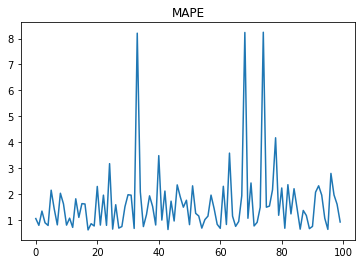

In [37]:
plt.title("MAPE")
plt.plot(df_res['MAPE'])
plt.show()

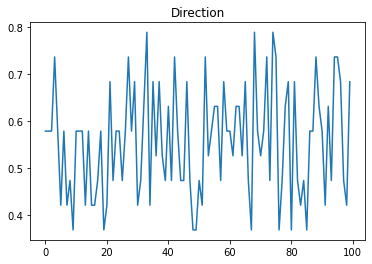

In [38]:
plt.title("Direction")
plt.plot(df_res['Direction'])
plt.show()